# HLAthena
### A Python package for HLA class I peptide analysis, binding prediction, and model training

## Installation

To install hlathena run: 

    git clone https://github.com/ssarkizova/hlathenav2
    cd hlathenav2
    pip install .

## Usage

#### Importing the package

In [1]:
import hlathena as ht 

Next, we'll import some example data

In [2]:
import pandas as pd
sample_pep_file = "A0101_filtered.txt"
df = pd.read_table(sample_pep_file)
pep_col = 'seq' # column containing peptide sequences
peptides = list(df[pep_col])

In [3]:
df.head()

,allele,length,seq,score,backbone_cleav,totalIntensity,hg19.kgXref.geneSymbol
0,A0101,8,ADMGHLKY,16.74,7,23600000.0,PCNA
1,A0101,8,ELDDTLKY,9.66,6,30300000.0,PPP2CA
2,A0101,8,FSDNIEFY,8.51,6,950000.0,NUP107
3,A0101,8,FTELAILY,8.76,6,39900000.0,CLTC
4,A0101,8,GLDEPLLK,9.22,6,31400000.0,HLA-DQA2


### Peptide analysis

First, we'll plot the length distribution of the peptide set.

<AxesSubplot:title={'center':'Length distribution (n=1383)'}>

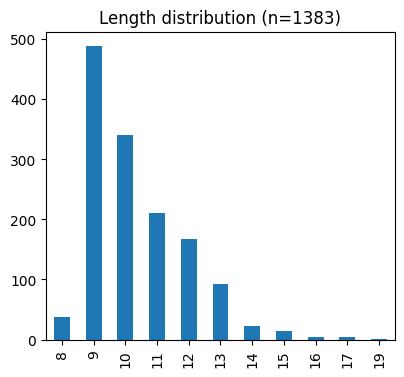

In [4]:
ht.plot_length(df)

Next, we'll visualize the amino acid motifs of this peptide set

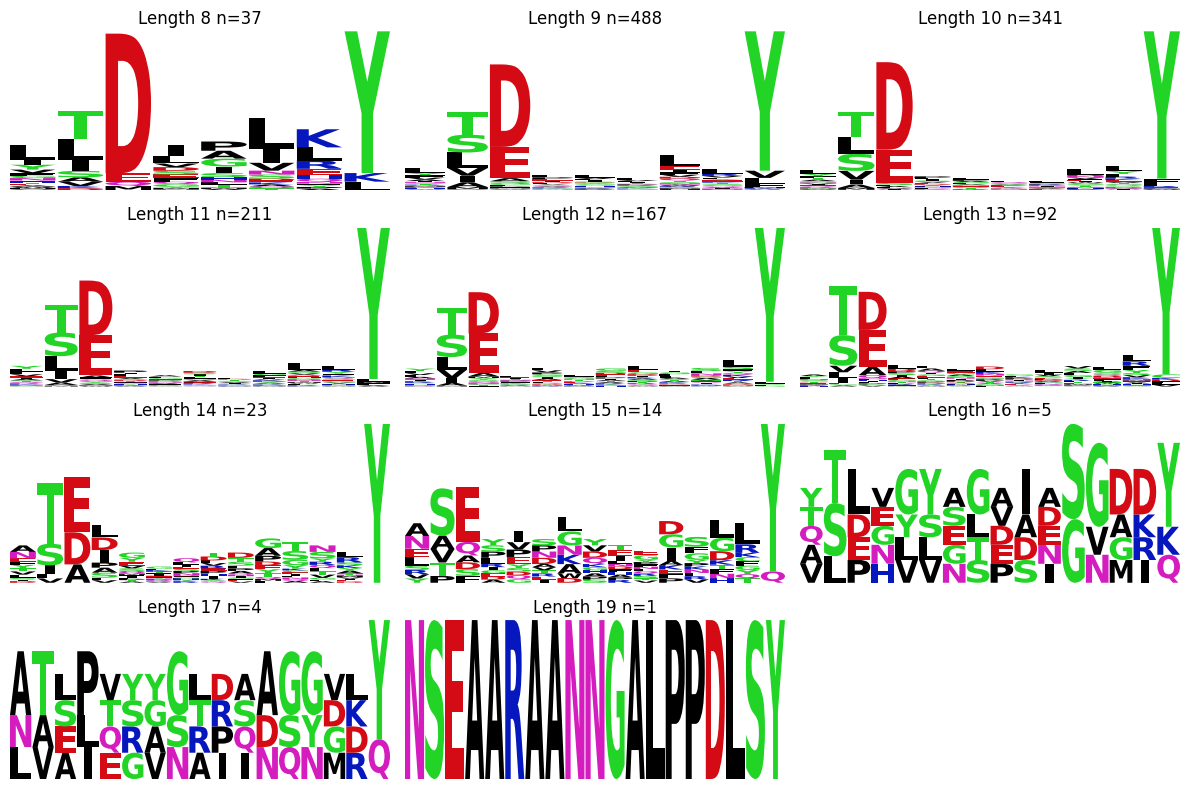

In [5]:
ht.plot_logo(df, pep_col = pep_col)

Let's examine the 9mer's motif more closely

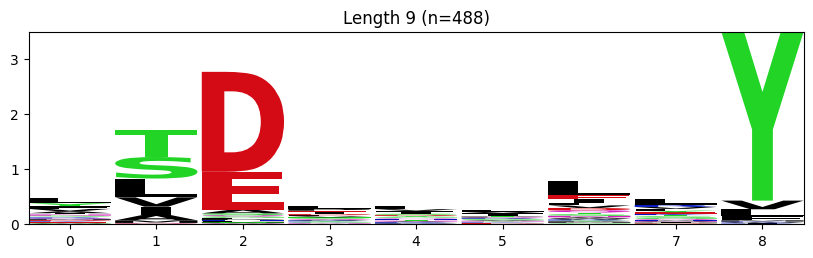

In [6]:
ht.plot_logo(df, length=9, pep_col=pep_col)

Next, we want to cluster these peptides with a UMAP. First, we'll neeed to do some dimensionality reduction using the peptide projection module.

We will specify that we want to use Kidera Factors for the amino acid encoding by providing a file path. Additional files with amino acid encodings can be included (they must be tab-delimited txt files with one row per amino acid symbol and 1+ columns). 

We will also save this encoding in case we want to re-use it later.

In [7]:
feature_matrix = ht.PCA_encode(peptides, 'A0101', 9, aa_featurefiles=['kideraFactors.txt'], save_PCA_path='pca_encoding.npz')

Now we can make a simple UMAP plot:

In [8]:
umap_embedding = ht.get_umap_embedding(feature_matrix)

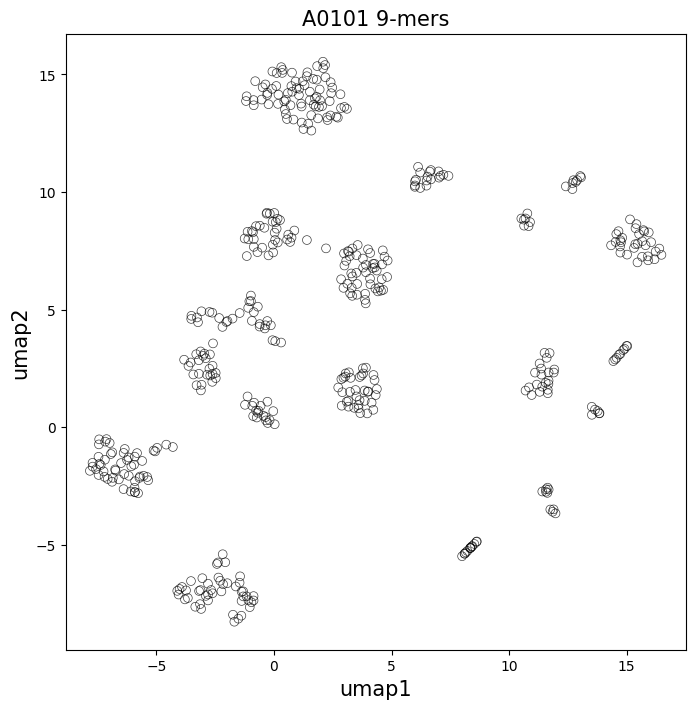

In [9]:
ht.plot_umap(umap_embedding, title='A0101 9-mers')

In [10]:
peptide_clustering = ht.get_peptide_clustering(umap_embedding)

In [11]:
peptide_clustering.head()

,seq,d1,d2,cluster
0,AADIFYSRY,-3.431883,2.235728,0
1,AADLNLVLY,-3.191769,2.265935,0
2,AADLVEALY,-2.610976,2.252813,0
3,AIDEDVLRY,15.474375,7.795236,2
4,AIDLLKEIY,15.372466,7.77986,2


In [12]:
merged = peptide_clustering.merge(df, on='seq')

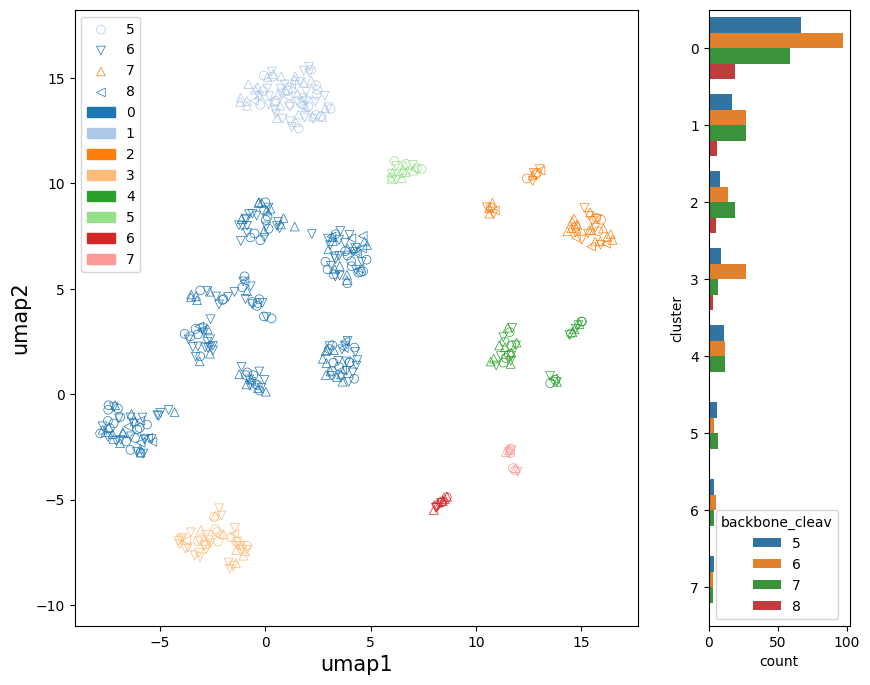

In [13]:
ht.plot_umap(merged, clustered=True, label_col='backbone_cleav')

### Annotate peptide set

In [14]:
pep_df = pd.DataFrame(peptides, columns=['seq'])
annotated_peptides = ht.get_reference_gene_ids(pep_df, add_context=True)
annotated_peptides.head()

,seq,Hugo_Symbol,ctex_up,ctex_dn
0,YSDVAKGILQY,SPATA20,HVPHFEKMLYDQAQLAVAYSQAFQLSGDEF,VARSLSHRSGGFYSAEDADSPPERGQRPK-
1,HIDFGGTSVWY,KDM7A,ENYWPDDSVFPKPFVQKYCLMGVQDSYTDF,HVLWGEKIFYLIKPTDENLARYESWSSSV-
2,YLETVAAYY,IL32,PKVLSDDMKKLKARMVMSSLAELEDDFKEG,EEQHPELTPLLEKERDGLRCRGNRSPVPD-
3,LSELFMSSFQSY,IL32,GVLAWVKEKVVALVHAVQALWKQFQSFCCS,GAPRGDKEELTPQKCSEPQSSK--------
4,HSEFLTVPAGSY,HIVEP2,LSHSSSFSMSFEREETSKLSALPKQDEFGK,SLSVPGHHHQKEMRRCSSEQMPCPHPAEV-


Next, we will annotate with TCGA reference data. In order to determine which options are available and/or the TCGA cancer type abbreviation, we call the ```list_expression_references()``` function. In this case, we will annotate with reference breast cancer expression data. 

In [15]:
ht.list_tcga_expression_references().head()

,Study Name
Study Abbreviation,
LAML,Acute Myeloid Leukemia
ACC,Adrenocortical carcinoma
BLCA,Bladder Urothelial Carcinoma
LGG,Brain Lower Grade Glioma
BRCA,Breast invasive carcinoma


 We find the relevant TCGA abbreviation and call ```add_tcga_expression```.

In [16]:
annotated_peptides = ht.add_tcga_expression(annotated_peptides, 'BRCA')

### Example GSEA Analysis

To do gene set enrichment analysis (GSEA) on this peptide set, we first create a gene/avg. sample expression matrix. In this case we will use BRCA_TPM as our sample values.



In [17]:
import gseapy as gp

In [18]:
IFN_response_genes = pd.read_table('HALLMARK_INTERFERON_GAMMA_RESPONSE.v2023.1.Hs.txt',header=None)
IFN_response_genes = list(IFN_response_genes[0])

In [19]:
IFNy_samples = pd.read_excel('IFNy_sample_data/41587_2019_322_MOESM10_ESM - NBT 2019 Supp6.xlsx', usecols=['Clinical ID','Type','Length','Peptide'])
GBM = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187']
GBM_IFN = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187_IFN']



In [20]:
GBM = ht.get_reference_gene_ids(GBM, pep_col='Peptide', add_context=False)
GBM_IFN = ht.get_reference_gene_ids(GBM_IFN, pep_col='Peptide', add_context=False)

We count the number of peptides from IFN response genes according to our gene annotations:

In [21]:
GSEA_GBM = gp.enrichr(gene_list=list(GBM['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_GSEA_results')
GSEA_GBM_IFN = gp.enrichr(gene_list=list(GBM_IFN['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_IFN_GSEA_results')

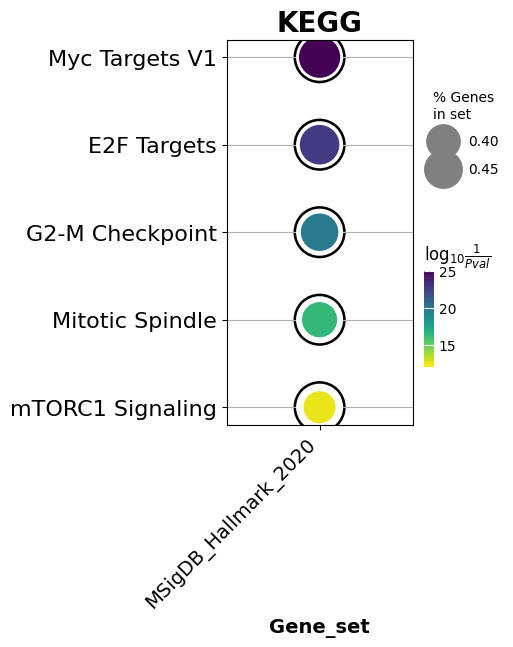

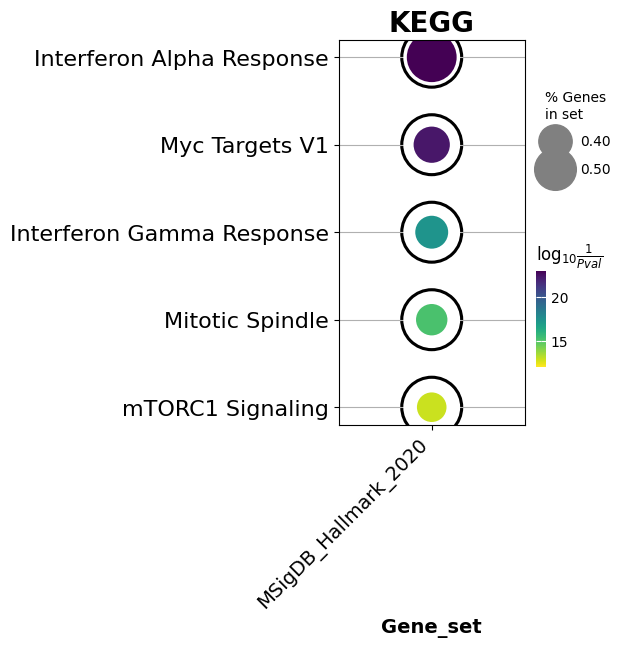

In [22]:
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt

ax1 = dotplot(GSEA_GBM.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )
ax2 = dotplot(GSEA_GBM_IFN.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )


### Clustering and comparing the GBM peptides

In [23]:
GBM['label'] = 'GBM'
GBM_IFN['label'] = 'GBM_with_IFN'
full_GBM_df = pd.concat([GBM,GBM_IFN])
full_GBM_df.head()

,seq,Hugo_Symbol,label
0,LAAGHLVQL,CYP51A1,GBM
1,TMVGKTFTY,CYP51A1,GBM
2,HTSSTTSAW,CYP51A1,GBM
3,YTIPPGHQV,CYP51A1,GBM
4,GSDVVDWLY,DVL2,GBM


To make a UMAP comparison, we'll need to select a particular length. We can once again use the ```plot_length``` function to find the length distribution of the combined dataset.

<AxesSubplot:xlabel='length', ylabel='count'>

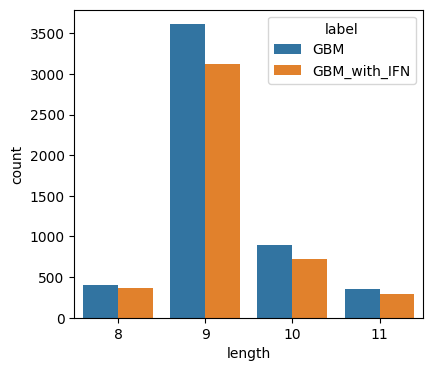

In [24]:
ht.plot_length(full_GBM_df, pep_col='seq', label_col='label')

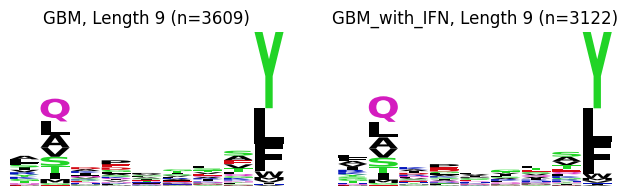

In [25]:
ht.plot_logo(full_GBM_df, length=9, pep_col='seq', label_col='label')

### Peptide binding prediction

In [26]:
model_path = '../models/NN-time2022-12-16_10-fold0.pt'

ninemers = [pep for pep in peptides if len(pep)==9] # create list of ninemers 
ht.predict(model_path, ninemers)

,seq,score
0,AADIFYSRY,3.535182713676477e-06
1,AADLNLVLY,9.253981261281297e-06
2,AADLVEALY,9.627723329685978e-07
3,AIDEDVLRY,1.6805062841740437e-05
4,AIDLLKEIY,1.499109316682734e-06
...,...,...
483,YTSDYFISY,0.0007096683839336038
484,YVDDVFLRV,0.953221321105957
485,YVDPQFLTY,9.512112592346966e-05
486,YVEKFALNY,1.3267753274703864e-05
